In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import numpy as np
import cirq
import sympy
import matplotlib.pyplot as plt

from qbitmap import diagnostics

# Response matrix

Here we describe readout error as a classical stochastic process characterized by a "response matrix" $R$ describing transition probabilities between an input computational basis state and an observed bitstring. The response matrix $R$ is defined elementwise in terms of transition likelihoods,
\begin{equation}\label{eq:bf_prob}
R_{ij} \equiv p(i||j\rangle) = p(i_1\dots i_n | |j_1 \dots j_n\rangle)
\end{equation}
where $i,j\in\{0,1\}^n$ are length-$n$ bitstrings, and the notation $i_k$ is understood to refer to the $k$-th bit of $i$.



## Separable readout error diagnostic

This diagnostic measures $Q$ matrices of the following form

$$
 Q_k = \begin{pmatrix}
    1 - q_k(1|0) & q_k(0|1) \\
    q_k(1|0) & 1 - q_k(0|1)
   \end{pmatrix}
$$
where $q_k(i|j)$ is the bitwise conditional probability for observing bit "i" after attempting measurement on $|j\rangle$. This diagnostic assumes a readout error behavior with minimal correlation between bitflips on different qubits, reducing determination of $R = \otimes_{k=1}^n Q_k$ from complexity $2^n$ to complexity $2n$ at the expense of (possibly large) innaccuracy in $R$. Note that this separable model is oftenstimes the _only_ tractable model for arbitrarily large errror rates since $R^{-1} = \otimes_{k=1}^n Q_k^{-1}$ can be trivially computed if separability holds.

To remove some bias from state preparation error, this diagnostic computes each $q_k$ using a series of trials on random computaional basis states $|s\rangle$ and $|s \oplus 1^n\rangle$ for $s \in \{0,1\}^n$.

In [117]:
def R_from_qvals(q01, q10, n):
    Qmats = []
    for i in range(n):
        Q = np.asarray([
            [1 - q10[i], q01[i]],
            [q10[i], 1 - q01[i]]
        ])
        Qmats.append(Q)

    R = Qmats[0]
    for i in range(1, n):
        R = np.kron(R, Qmats[i])
    return R

In [118]:
n = 4
qubits = cirq.GridQubit.rect(1, n)

sep_diagnostic = diagnostics.SeparableReadoutErrorDiagnostic(
    timestamp="TEST",
    qubits=qubits,
    repetitions=10000,
    debug=True,
    path="./scratch"
)
qvals = sep_diagnostic.run(ntrials=4)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa8f3920e10>)

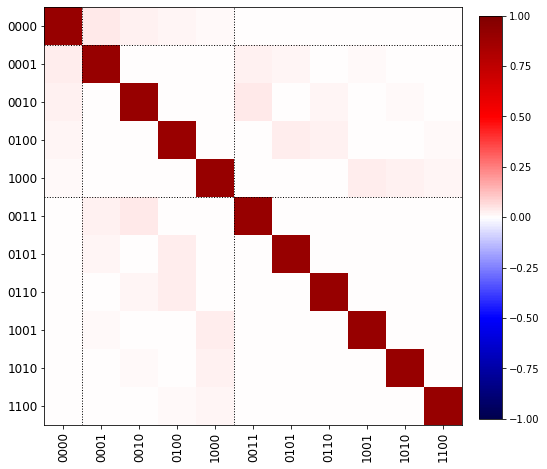

In [120]:
pert_diagnostic = diagnostics.ReadoutErrorDiagnostic(
    timestamp="TEST",
    qubits=qubits,
    repetitions=10000,
    cutoff=2,
    debug=True,
    path="./scratch"
)
Rpert = pert_diagnostic.run()
pert_diagnostic.plot()

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa8f0fa3d30>)

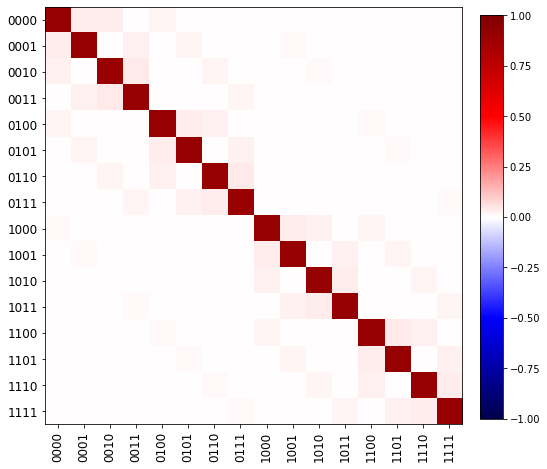

In [121]:
full_diagnostic = diagnostics.ReadoutErrorDiagnostic(
    timestamp="TEST",
    qubits=qubits,
    repetitions=10000,
    cutoff=None,
    debug=True,
    path="./scratch"
)
Rfull = full_diagnostic.run()
full_diagnostic.plot()

In [122]:
# These two matrices should be almost identical up to statistical error
flip_probs =  [.01 * (j+1) for j in range(n)]
R_debug = R_from_qvals(flip_probs, flip_probs, n)
(full_diagnostic.R - R_debug).max()

0.00564976000000017

## Open swim: Compare separable readout to full readout error

Here we're investigating whether the separable model for readout error (assuming minimal crosstalk) is a "good model" for predicting a true transition matrix. This just means comparing $R$ to $\bigotimes_{k=1}^n Q_k$.

In [123]:
from qbitmap import hw
from qbitmap import calibration_data

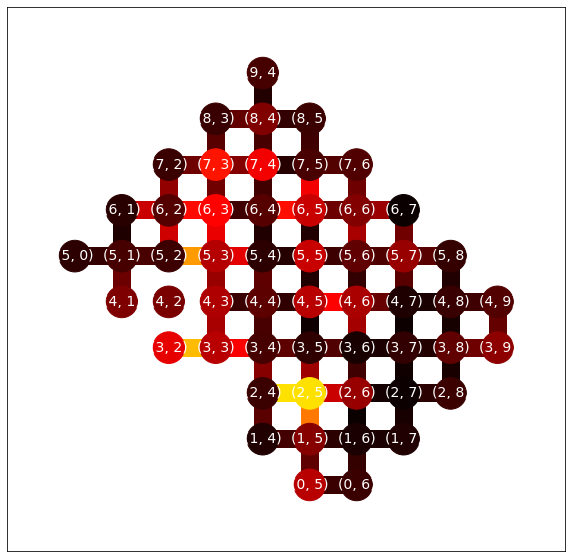

In [124]:
current_calibration = hw.PROCESSOR.get_current_calibration()
all_qubits = hw.DEVICE.qubits
calibration = calibration_data.CalibrationWrapper(calibration_dct=current_calibration, qubits=all_qubits)

fig, ax = plt.subplots(figsize=(10, 10))
calibration.plot_noise_graph(ax=ax)
print()


In [125]:
# Use this calibration data's timestamp as a reference
TIMESTAMP = current_calibration.timestamp
PATH = "./readout_error"

n = 4
idx = [(6,3), (6, 4), (7, 3), (7, 4)]
QUBITS = [cirq.GridQubit(*xy) for xy in idx]


### Compute a separable diagnostic

This computes $Q_k$ matrices for each qubit cheaply, then tensors them together to approximate $R$.

In [126]:
# Run the separable (uncorrelated error model) diagnostic
hw_diagnostic_sep = diagnostics.SeparableReadoutErrorDiagnostic(
    timestamp=TIMESTAMP,
    qubits=QUBITS,
    repetitions=10000,
    debug=False,
    path=PATH
)

qvals = hw_diagnostic_sep.run(ntrials=4)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa8f073f048>)

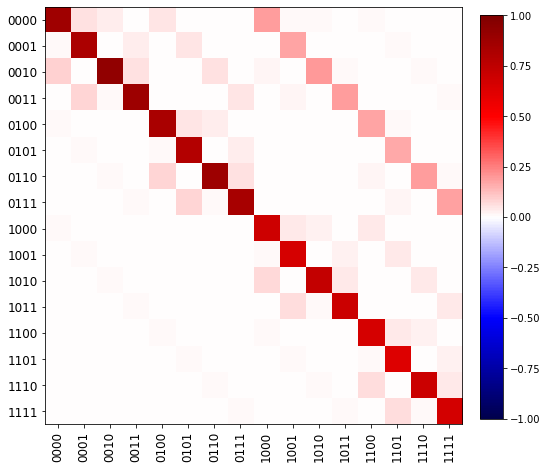

In [127]:
# Construct the (tensored) response matrix
Qmats_sep = hw_diagnostic_sep.make_response_matrices(qvals)

R_sep = Qmats_sep[0]
for i in range(1, n):
    R_sep = np.kron(R_sep, Qmats_sep[i])

diagnostics.plot_response_matrix(R_sep, n, targets=np.arange(1 << n), cutoff=None)

### Run a full experiment

Compute each p(i| |j>) separately for each computational basis state

In [128]:
# Run the full (correlated error model) diagnostic

hw_diagnostic_full = diagnostics.ReadoutErrorDiagnostic(
    timestamp=TIMESTAMP,
    qubits=QUBITS,
    repetitions=10000,
    cutoff=None,
    debug=False,
    path=PATH
)

R_full = hw_diagnostic_full.run()

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa8f0696ef0>)

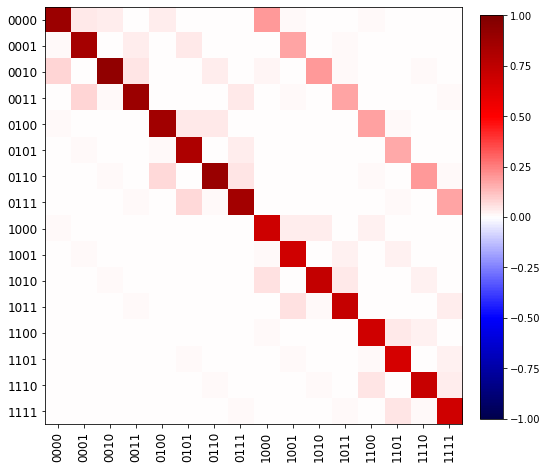

In [129]:
hw_diagnostic_full.plot()

### Compare the separable diagnostic to the full diagnostic

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa8f05eeda0>)

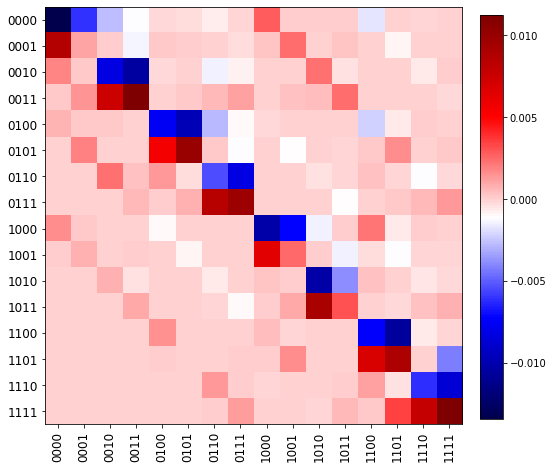

In [130]:
kwargs = {'cmap': 'seismic', 'vmin': diff.min(), 'vmax': diff.max()}
diagnostics.plot_response_matrix(diff, n, targets=np.arange(1 << n), cutoff=None, **kwargs)


### Compare our separable diagnostic to the latist calibration data

This should be taken with a grain of salt due to stale diagnostics, but worth looking at.

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa8f05ee160>)

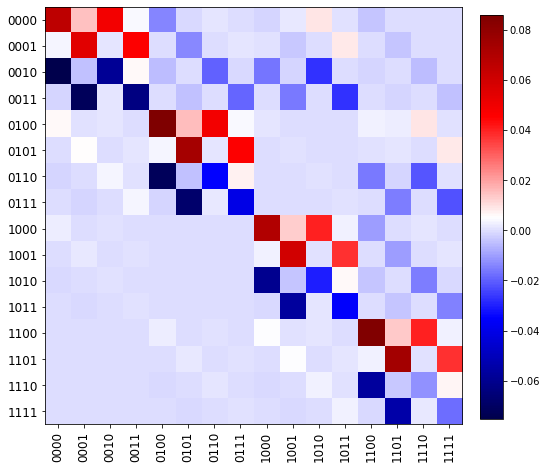

In [131]:
q01 = [current_calibration.get("single_qubit_p11_error").get((q,))[0] for q in QUBITS]
q10 = [current_calibration.get("single_qubit_p00_error").get((q,))[0] for q in QUBITS]
R_calib = R_from_qvals(q01, q10, n)
diff2 = R_calib - R_sep
kwargs = {'cmap': 'seismic', 'vmin': diff2.min(), 'vmax': diff2.max()}
diagnostics.plot_response_matrix(diff2, n, targets=np.arange(1 << n), cutoff=None, **kwargs)
